<a href="https://www.kaggle.com/code/junaeidali123/x-ray-bone-fracture-ssl-flex-match?scriptVersionId=259207231" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Important Libaries

In [1]:
!pip -q install timm==0.9.16 albumentations==1.4.8 --no-warn-script-location
!pip install --upgrade albumentations albucore


import os, math, time, json, random
from pathlib import Path
from collections import defaultdict

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset, RandomSampler, SequentialSampler
from torchvision import datasets, transforms
from torchvision.transforms import InterpolationMode
import timm

from albumentations import (
    Compose, RandomResizedCrop, HorizontalFlip, ShiftScaleRotate,
    RandomBrightnessContrast, GaussNoise
)
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import classification_report, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Repro
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 104.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21

# Dataset Splitting + Save JSON

In [2]:
# =========================
# Part 1: Dataset Splitting
# =========================
import os, json, random
from collections import Counter
from sklearn.model_selection import train_test_split

# Reproducibility
SEED = 42
random.seed(SEED)

# Dataset root
DATA_DIR = "/kaggle/input/x-ray-bone-fracture-dataset/X-ray Bone Fracture Dataset Comprehensive Imaging for Fracture Classification and Medical Research/Bone -Fracture/Bone Fracture/Orginal"

# Collect (path, label)
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}
def is_image(fname): return os.path.splitext(fname)[1].lower() in IMG_EXTS

classes = [d for d in sorted(os.listdir(DATA_DIR)) if os.path.isdir(os.path.join(DATA_DIR, d))]
class_to_idx = {c: i for i, c in enumerate(classes)}

samples = []
for c in classes:
    cdir = os.path.join(DATA_DIR, c)
    for fname in os.listdir(cdir):
        if is_image(fname):
            samples.append((os.path.join(cdir, fname), class_to_idx[c]))

print(f"Total images: {len(samples)}, Classes: {classes}")

# --- 80/10/10 split
y_all = [y for _, y in samples]
trainval, test = train_test_split(samples, test_size=0.10, stratify=y_all, random_state=SEED)
y_trainval = [y for _, y in trainval]
train, val = train_test_split(trainval, test_size=0.111, stratify=y_trainval, random_state=SEED)
print(f"Train={len(train)}, Val={len(val)}, Test={len(test)}")

# --- Train → 20% labeled, 80% unlabeled
y_train = [y for _, y in train]
labeled, unlabeled = train_test_split(train, test_size=0.80, stratify=y_train, random_state=SEED)
print(f"Labeled={len(labeled)}, Unlabeled={len(unlabeled)}")

# --- Save JSON
splits = {
    "class_to_idx": class_to_idx,
    "labeled": labeled,
    "unlabeled": unlabeled,
    "val": val,
    "test": test
}
with open("splits.json", "w") as f: json.dump(splits, f, indent=2)
print("Saved splits.json in notebook output")


Total images: 2384, Classes: ['Comminuted Bone Fracture', 'Simple Bone Fracture']
Train=1906, Val=239, Test=239
Labeled=381, Unlabeled=1525
Saved splits.json in notebook output


# Datasets + Augmentations + DataLoaders

In [3]:
# =========================
# Part 2: Dataset & Dataloaders
# =========================
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Load splits.json
with open("splits.json", "r") as f:
    splits = json.load(f)

class_to_idx = splits["class_to_idx"]
labeled = splits["labeled"]
unlabeled = splits["unlabeled"]
val = splits["val"]
test = splits["test"]

# --- Dataset Classes ---
class LabeledDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert("RGB")
        if self.transform: image = self.transform(image)
        return image, label

class UnlabeledDataset(Dataset):
    def __init__(self, samples, weak_transform=None, strong_transform=None):
        self.samples = samples
        self.weak_transform = weak_transform
        self.strong_transform = strong_transform

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]  # label unused
        image = Image.open(path).convert("RGB")
        weak_img = self.weak_transform(image)
        strong_img = self.strong_transform(image)
        return weak_img, strong_img

# --- Augmentations ---
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

weak_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

strong_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(0.4,0.4,0.4,0.1)], p=0.8),
   
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# --- Build datasets & loaders ---
batch_size_labeled = 16
batch_size_unlabeled = 16

labeled_dataset = LabeledDataset(labeled, transform=weak_transform)
unlabeled_dataset = UnlabeledDataset(unlabeled, weak_transform=weak_transform, strong_transform=strong_transform)
val_dataset = LabeledDataset(val, transform=val_test_transform)
test_dataset = LabeledDataset(test, transform=val_test_transform)

labeled_loader = DataLoader(labeled_dataset, batch_size=batch_size_labeled, shuffle=True, num_workers=2)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size_unlabeled, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(" Dataloaders ready.")


 Dataloaders ready.


# Model (EfficientNetV2-Small)

In [4]:
# =========================
# Part 3: Model
# =========================
import timm
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(class_to_idx)
model = timm.create_model("efficientnetv2_s", pretrained=False, num_classes=num_classes)
model = model.to(device)

# Freeze 25% of layers for first few epochs
def freeze_layers(model, freeze_ratio=0.25):
    layers = list(model.children())
    num_freeze = int(len(layers) * freeze_ratio)
    for layer in layers[:num_freeze]:
        for param in layer.parameters():
            param.requires_grad = False
freeze_layers(model)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

print(" Model ready.")


 Model ready.


# FlexMatch Loss

In [5]:
# =========================
# Part 4: FlexMatch Loss
# =========================
import torch.nn.functional as F

def flexmatch_loss(logits_x, targets_x, logits_u_w, logits_u_s, class_acc, tau=0.95, lambda_u=1.0):
    # --- Supervised loss ---
    Lx = criterion(logits_x, targets_x)

    # --- Pseudo-labels (weak augmented) ---
    probs = torch.softmax(logits_u_w, dim=-1)
    max_probs, targets_u = torch.max(probs, dim=-1)

    # --- Per-class dynamic threshold ---
    mu = 1.0
    thresholds = torch.tensor([tau * (class_acc[c].item() ** mu + 1e-6) for c in targets_u]).to(device)

    mask = max_probs.ge(thresholds).float()

    # --- Unsupervised loss (strong augmented) ---
    Lu = (F.cross_entropy(logits_u_s, targets_u, reduction="none") * mask).mean()

    return Lx, lambda_u * Lu, mask.mean()


# Training Loop

Epoch [1/75] Loss=3.6856 Lx=2.3119 Lu=1.3737 Val Acc=0.5439 F1=0.4269
Epoch [2/75] Loss=1.6482 Lx=0.9293 Lu=0.7189 Val Acc=0.5565 F1=0.4646
Epoch [3/75] Loss=1.7432 Lx=0.8597 Lu=0.8835 Val Acc=0.6025 F1=0.5652
Epoch [4/75] Loss=1.3237 Lx=0.7363 Lu=0.5874 Val Acc=0.5858 F1=0.5335
Epoch [5/75] Loss=1.3750 Lx=0.8148 Lu=0.5603 Val Acc=0.5774 F1=0.5146
Unfreezing all layers at epoch 5
Epoch [6/75] Loss=1.4156 Lx=0.8341 Lu=0.5815 Val Acc=0.5858 F1=0.5061
Epoch [7/75] Loss=1.4021 Lx=0.7989 Lu=0.6032 Val Acc=0.6485 F1=0.6205
Epoch [8/75] Loss=1.4676 Lx=0.8129 Lu=0.6547 Val Acc=0.5900 F1=0.5168
Epoch [9/75] Loss=1.5594 Lx=0.8632 Lu=0.6961 Val Acc=0.5607 F1=0.5605
Epoch [10/75] Loss=1.4668 Lx=0.7444 Lu=0.7224 Val Acc=0.5732 F1=0.4759
Epoch [11/75] Loss=1.5631 Lx=0.8247 Lu=0.7383 Val Acc=0.5439 F1=0.4156
Epoch [12/75] Loss=1.4905 Lx=0.7629 Lu=0.7276 Val Acc=0.5607 F1=0.5480
Epoch [13/75] Loss=1.4269 Lx=0.6803 Lu=0.7466 Val Acc=0.5230 F1=0.5186
Epoch [14/75] Loss=1.5977 Lx=0.8606 Lu=0.7370 Val Acc

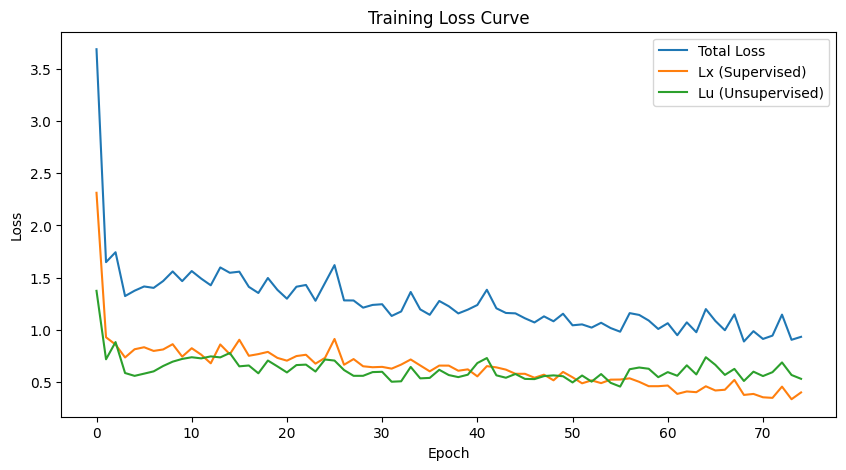

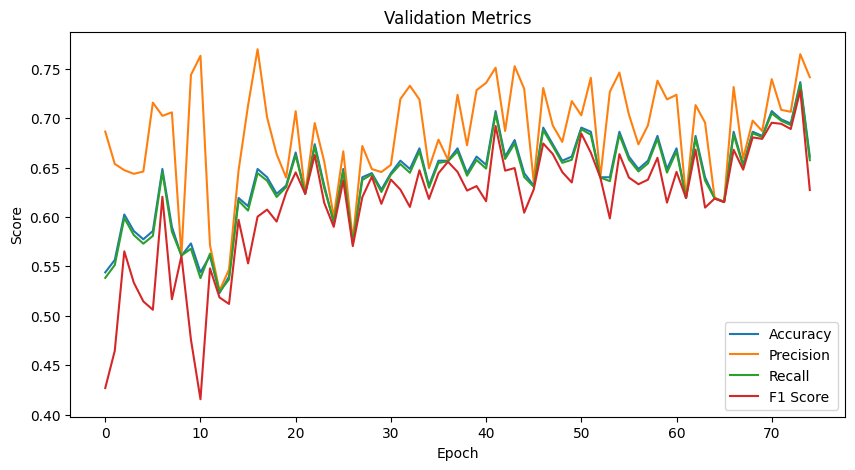

In [6]:
# =========================
# Part 5: Training + Validation + Loss Curve
# =========================
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

num_epochs = 75
freeze_epochs = 5   # freeze first 5 epochs
lambda_u, tau = 1.0, 0.9

class_acc = torch.zeros(num_classes).to(device)  # per-class curriculum tracker

# --- Function to freeze / unfreeze layers ---
def set_parameter_requires_grad(model, freeze=True, ratio=0.25):
    total = len(list(model.parameters()))
    cutoff = int(total * ratio)
    for i, param in enumerate(model.parameters()):
        if i < cutoff:
            param.requires_grad = not freeze
        else:
            param.requires_grad = True

# initially freeze 25% of layers
set_parameter_requires_grad(model, freeze=True, ratio=0.25)

# trackers
train_losses, train_lx, train_lu = [], [], []
val_accs, val_precisions, val_recalls, val_f1s = [], [], [], []

for epoch in range(num_epochs):
    # ---- unfreeze after freeze_epochs ----
    if epoch == freeze_epochs:
        print(f"Unfreezing all layers at epoch {epoch}")
        set_parameter_requires_grad(model, freeze=False, ratio=0.25)

    model.train()
    total_loss, total_lx, total_lu = 0, 0, 0
    unlabeled_iter = iter(unlabeled_loader)

    for batch_idx, (x, y) in enumerate(labeled_loader):
        try:
            u_w, u_s = next(unlabeled_iter)
        except StopIteration:
            unlabeled_iter = iter(unlabeled_loader)
            u_w, u_s = next(unlabeled_iter)

        x, y = x.to(device), y.to(device)
        u_w, u_s = u_w.to(device), u_s.to(device)

        # forward
        logits_x = model(x)
        logits_u_w = model(u_w)
        logits_u_s = model(u_s)

        # loss
        Lx, Lu, mask_mean = flexmatch_loss(
            logits_x, y, logits_u_w, logits_u_s,
            class_acc, tau, lambda_u
        )
        loss = Lx + Lu

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_lx += Lx.item()
        total_lu += Lu.item()

    # ---- validation ----
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            outputs = model(x_val)
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(y_val.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)

    # store results
    train_losses.append(total_loss / len(labeled_loader))
    train_lx.append(total_lx / len(labeled_loader))
    train_lu.append(total_lu / len(labeled_loader))
    val_accs.append(acc)
    val_precisions.append(prec)
    val_recalls.append(rec)
    val_f1s.append(f1)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Loss={train_losses[-1]:.4f} "
          f"Lx={train_lx[-1]:.4f} "
          f"Lu={train_lu[-1]:.4f} "
          f"Val Acc={acc:.4f} "
          f"F1={f1:.4f}")

# =========================
# Plot Loss Curve
# =========================
plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Total Loss")
plt.plot(train_lx, label="Lx (Supervised)")
plt.plot(train_lu, label="Lu (Unsupervised)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()

# =========================
# Plot Validation Metrics
# =========================
plt.figure(figsize=(10,5))
plt.plot(val_accs, label="Accuracy")
plt.plot(val_precisions, label="Precision")
plt.plot(val_recalls, label="Recall")
plt.plot(val_f1s, label="F1 Score")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Validation Metrics")
plt.legend()
plt.show()


# Evaluation

In [7]:
# =========================
# Part 6: Evaluation
# =========================
from sklearn.metrics import classification_report

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        preds = torch.argmax(logits, dim=1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(" Test Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(class_to_idx.keys())))


 Test Classification Report:
                          precision    recall  f1-score   support

Comminuted Bone Fracture       0.74      0.46      0.57       118
    Simple Bone Fracture       0.61      0.84      0.71       121

                accuracy                           0.65       239
               macro avg       0.68      0.65      0.64       239
            weighted avg       0.68      0.65      0.64       239

